In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [85]:
class DNN:
    """
    param layers : List of layers sizes with first element being the size of input layer
    param acts : list of activation functions for each layer with size one less than the size of layers. First element 
                 corresponds to the size of input layer and last layer corresponds to the output layer size
                 r - RELU
                 t - Tanh
                 s - Sigmoid
    iters : Maximum number of iterations for gradient descent
    mini_batc_size : Size to divide the input x into certain number of batches
    optimizer : Select an optimization train the model much better
                sgd : Stochastic Gradient Descent
                bgd : Batch Gradient Descent
                RMSprop : Gradient Descent with Momentum
                adam : Adaptive Moment Estimation for Gradient Descent
    plot_acc : Plots accuray at each epoch after training the model
    plot_des : Plots cost at each epoch after training the model
    
    """
    def __init__(self, layers, acts=None, iters=2500, lr=0.001, mini_batch_size=128, beta1=0.9, beta2=0.999,\
                  optimizer='bgd', plot_acc=0, plot_des=0):
        
        self.iters = iters
        self.layers = layers
        self.lr = lr
        self.epsilon = 1e-7
        self.beta1, self.beta2 = beta1, beta2
        self.ptac, self.ptdt = plot_acc, plot_des
        self.optimizer = optimizer
        self.mbs = mini_batch_size
        
        if self.optimizer=="sgd":
            self.mini_batch_size = 1
        else:
            self.mbs = mini_batch_size
            
        self.A, self.Z, self.W, self.B = {}, {}, {}, {}
        self.dvw, self.dvb, self.dw, self.db, self.dz = {}, {}, {}, {}, {}
        self.PA, self.PZ = {}, {}
        self.x, self.y, self.m, self.predictions = None, None, None, None
        self.mp, self.yp, self.xp = None, None, None
        self.acc, self.costs, self.mini_batches_x, self.mini_batches_y = [], [], [], []
        
        if acts:
            self.acts = acts
        else:
            self.acts = (['r']*(len(self.layers)-2))+['s']
            
        self.activations = {'r': self.relu, 't': self.tanh, 's': self.sigmoid}
        self.diff_activations = {'r': self.diff_relu, 't': self.diff_tanh}
    
    #Sigmoid Activation for the last layer
    def sigmoid(self, z):
        return 1/(1+np.exp(-z))
    
    #RELU Activation for hidden layers
    def relu(self, z):
        return np.maximum(0, z)
    
    #Tan hyperbolic Activation for hidden layers
    def tanh(self, z):
        return np.tanh(z)
    
    #Differentation of tanh activation for back propagation
    def diff_tanh(self, z):
        return 1-np.square(self.tanh(z))
    
    #Differentation of RELU activation for back propagation
    def diff_relu(self, z):
        return np.where(z>0, 1, 0)
    
    #Train method for the model
    def fit(self, x, y):
        
        self.x, self.xp = x.T, x
        self.y = y.reshape((1, -1))
        self.yp = y.reshape((1, -1))
        self.m, self.mp = x.shape[0], x.shape[0]
        self.A['A0'] = self.x
        
        self.initialize_weights()
        self.create_mini_batches()
        self.optimize_weights()
        
        if self.ptdt:
            self.plot_descent()
        if self.ptac:
            self.plot_accuracy()
    
    #For predicting test set after training the model
    def predict(self, x):
        
        self.PA['PA0'] = x.T
        for i in range(1, len(self.layers)):
            self.PZ['PZ'+str(i)] = (self.W['W'+str(i)]@self.PA['PA'+str(i-1)])+self.B['B'+str(i)]
            self.PA['PA'+str(i)] = self.activations[self.acts[i-1]](self.PZ['PZ'+str(i)])
        self.predictions = np.round(self.PA['PA'+str(len(self.layers)-1)])
        return self.predictions
    
    #Initializes weights for the model
    def initialize_weights(self):
        
        for i in range(1, len(self.layers)):
            self.W['W'+str(i)] = np.random.random((self.layers[i], self.layers[i-1]))*np.sqrt(2/self.layers[i-1])
            self.B['B'+str(i)] = np.random.random((self.layers[i], 1))*0.001
            self.dvw['dvw'+str(i)] = np.zeros((self.layers[i], self.layers[i-1]))
            self.dvb['dvb'+str(i)] = np.zeros((self.layers[i], 1))
    
    #As the name suggests it optimizes the weights and biases for the model
    def optimize_weights(self):
        
        for i in range(self.iters):
            for x, y in zip(self.mini_batches_x, self.mini_batches_y):
                self.x = x
                self.y = y
                self.m = self.x.shape[1]
                self.A['A0'] = self.x
                self.forward_propagation()
                self.backward_propagation()
                for i in range(1, len(self.layers)):
                    if self.optimizer=="RMSprop":
                        self.gd_momentum()
                        self.W['W'+str(i)] -= self.lr*self.dvw['dvw'+str(i)]
                        self.B['B'+str(i)] -= self.lr*self.dvb['dvb'+str(i)]
                    elif self.optimizer=="adam":
                        pass
                    else:
                        self.W['W'+str(i)] -= self.lr*self.dw['dw'+str(i)]
                        self.B['B'+str(i)] -= self.lr*self.db['db'+str(i)]
            self.costs.append(self.compute_cost())
            self.predict(self.xp)
            self.acc.append(self.accuracy())
    
    #Calculates A and Z for the model
    def forward_propagation(self):
        
        for i in range(1, len(self.layers)):
            self.Z['Z'+str(i)] = (self.W['W'+str(i)]@self.A['A'+str(i-1)])+self.B['B'+str(i)]
            self.A['A'+str(i)] = self.activations[self.acts[i-1]](self.Z['Z'+str(i)])
    
    #Calculates gradients for optimizing weights
    def backward_propagation(self):
        
        for i in range(1, len(self.layers))[::-1]:
            if i==len(self.layers)-1:
                self.dz['dz'+str(i)] = self.A['A'+str(i)] - self.y
            else:
                self.dz['dz'+str(i)] = (self.W['W'+str(i+1)].T@self.dz['dz'+str(i+1)])\
                                        *self.diff_activations[self.acts[i-1]](self.Z['Z'+str(i)])
            self.dw['dw'+str(i)] = (self.dz['dz'+str(i)]@self.A['A'+str(i-1)].T)/self.m
            self.db['db'+str(i)] = (np.sum(self.dz['dz'+str(i)], axis=1, keepdims=True))/self.m
            
    def gd_momentum(self):
        
        for i in range(1, len(self.layers)):
            self.dvw['dvw'+str(i)] = self.beta1*self.dvw['dvw'+str(i)] + (1-self.beta1)*self.dw['dw'+str(i)]
            self.dvb['dvb'+str(i)] = self.beta1*self.dvb['dvb'+str(i)] + (1-self.beta1)*self.db['db'+str(i)]
    
    #Computes the cost or error of the model
    def compute_cost(self):
        
        term1 = -self.y*np.log(self.A['A'+str(len(self.layers)-1)]+self.epsilon)
        term2 = -(1-self.y)*np.log(1-self.A['A'+str(len(self.layers)-1)]+self.epsilon)
        cost = np.sum(term1+term2)/self.m
        return cost
    
    #Metric method to calculate Accuracy
    def accuracy(self):
        
        acc = np.sum(self.yp==self.predictions)/self.yp.size
        return acc*100
    
    #Creates Mini Batches
    def create_mini_batches(self):
        
        start, end = 0, self.mbs
        if self.mbs<self.x.shape[1]:
            for i in range(math.ceil(self.x.shape[1]/self.mbs)):
                if i==math.ceil(self.x.shape[1]/self.mbs)-1:
                    self.mini_batches_x.append(self.x[:, start:])
                    self.mini_batches_y.append(self.y[:, start:])
                else:
                    self.mini_batches_x.append(self.x[:, start:end])
                    self.mini_batches_y.append(self.y[:, start:end])
                start += self.mbs
                end += self.mbs
        else:
            self.mini_batches_x.append(self.x)
            self.mini_batches_y.append(self.y)

    #Plots Accuracy if chosen       
    def plot_accuracy(self):
        
        plt.figure(1)
        plt.plot(self.acc, color='r')
        plt.title('Accuracy for each Epoch')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
    
    #Plots the cost at each Epoch if chosen 
    def plot_descent(self):
        
        plt.figure(2)
        plt.plot(self.costs, color='green')
        plt.title('Descent Curve of Cost')
        plt.xlabel('Epochs')
        plt.ylabel('Cost')

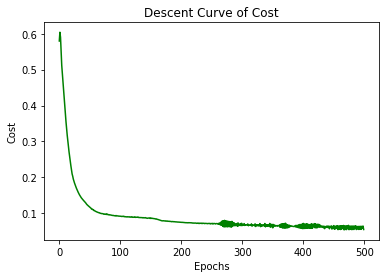

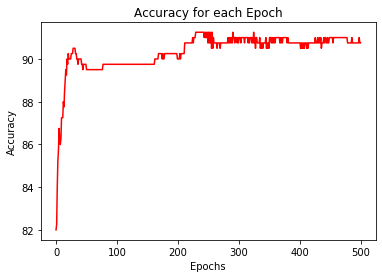

In [86]:
data = pd.read_csv('Social_Network_Ads.csv')
x = data.iloc[:, [2,3]].values
y = data.iloc[:, -1].values
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(x)
nn = DNN(layers=[2,5,2,6,1,8,1], iters=500, lr=0.09, optimizer='RMSprop', plot_acc=1, plot_des=1)
nn.fit(x, y)

In [87]:
nn.acc[-1]

90.75